## Final Project

In [42]:
import numpy as np
import math
import matplotlib.pyplot as plt
from functools import reduce
print(f'Precision: {np.finfo(np.float32).eps}')

Precision: 1.1920928955078125e-07


Comparing different methods of interpolation on a given dataset, and at the end, evaluate with cross-validation. The dataset used is taken from the book, p. 141 Ex. 9:

| Time  | 0  | 3  | 5  | 8  | 13 |
|-------|----|----|----|----|----|
| Speed | 75 | 77 | 80 | 74 | 72 |

It describes the speed of a car during a random 13 second interval while driving. In the following, I will use several methods of interpolation to create a polynomial that fits this dataset. First, it makes sense to look at the data in a plot.

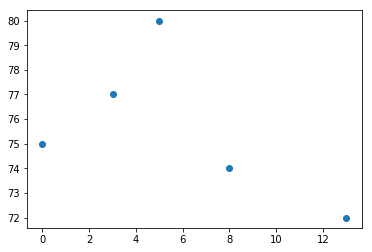

In [2]:
data1 = np.array([
    [0, 75],
    [3, 77],
    [5, 80],
    [8, 74],
    [13, 72]#,
    #[15, 78],
    #[21, 73],
    #[25, 74]
])
indices = np.linspace(0, data1[-1, 0], 130) # These indices will be used to evaluate the interpolated polynomials
plt.scatter(data1[:,0], data1[:,1], marker='o')
plt.show()

Now, this data will be interpolated using the different discussed mentioned in the book:
- Lagrange Interpolation
- Linear Interpolation
- Neville's Method
- Divided Differences
- Hermite Interpolation
- Cubic Spline Interpolation
- Parametric Curves

#### Lagrange Interpolation

First up, we have the Lagrange Interpolation polynomials.

In [3]:
def lagrange_polynomial_value(data, x):
    res = 0
    for i in range(len(data)):
        res += data[i, 1]*L(i, x, data)
    return res
    
def L(n, x, data):
    numerator = reduce(lambda a, b: a*b, [x - data[i,0] for i in range(len(data)) if i is not n])
    denominator = reduce(lambda a, b: a*b, [data[n, 0] - data[i, 0] for i in range(len(data)) if i is not n])
    return numerator/denominator

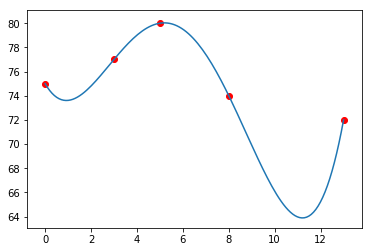

In [4]:
lagrange = np.array([[i, lagrange_polynomial_value(data1, i)] for i in indices])

plt.plot(lagrange[:,0], lagrange[:,1])
plt.scatter(data1[:, 0], data1[:, 1], marker='o', color='r')
plt.show()

In blue, we have the values of the Lagrange-Polynomial, and in red, we can see the actual data points.
Overall, the Lagrange Polynomial fits the data points quite accurate, even though some of the problems of Lagrange Polynomials can be observed: the interpolation shows high fluctuations between points that are a little further apart, whereas it would probably be more likely that the car drove with a steady distance.

#### Linear Interpolation

In [5]:
def piecewise_linear_interpolation_value(data, x):
    # Find appropriate indices for the dataset
    index = np.where(data[:,0] >= x)[0][0]
    return linear_fct(x, data[index-1], data[index])

def linear_interpolation_value(data, x):
    return linear_fct(x, data[0], data[-1])
    
def linear_fct(x, p1, p2):
    m = (p2[1] - p1[1])/(p2[0] - p1[0])
    b = p1[1] - p1[0]*m
    return m*x + b

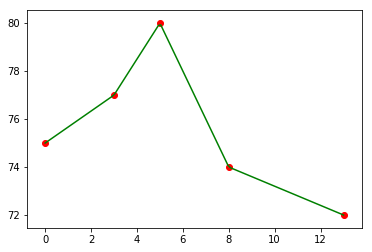

In [6]:
linear = np.array([[i, linear_interpolation_value(data1, i)] for i in indices])
piecewise_linear = np.array([[i, piecewise_linear_interpolation_value(data1, i)] for i in indices])

#plt.plot(linear[:,0], linear[:,1])
plt.plot(piecewise_linear[:, 0], piecewise_linear[:, 1], color='g')
plt.scatter(data1[:, 0], data1[:, 1], marker='o', color='r')
plt.show()

The piecewise linear interpolation fits the given data points very precise, but chances are high, that if there was another data point added to the dataset, this interpolation graph would not fit the point very well. Linear Interpolation results in a very overfitted graph.

#### Divided Differences

In [7]:
def newton_divided_differences(data, x):
    F = divided_differences(data)
    res = F[0]
    for i in range(1, len(F)):
        mult = reduce(lambda a, b: a*b, [x - data[j, 0] for j in range(i)])
        res += F[i]*mult
    return res
    
def divided_differences(data):
    coefficients = np.empty((len(data), len(data)))
    coefficients[:, 0] = data[:, 1]
    for i in range(1, len(data)):
        for j in range(1, i+1):
            coefficients[i, j] = (coefficients[i, j-1] - coefficients[i-1, j-1])/(data[i, 0] - data[i-j, 0])
    return np.diag(coefficients)

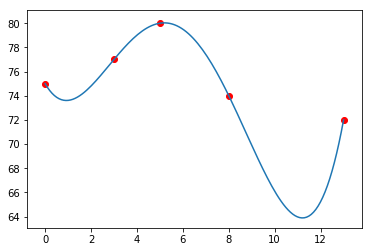

In [8]:
div_diff = np.array([[i, newton_divided_differences(data1, i)] for i in indices])

plt.plot(div_diff[:,0], div_diff[:,1])
plt.scatter(data1[:, 0], data1[:, 1], marker='o', color='r')
plt.show()

Gives the same result as the Lagrange Interpolation. Comparison Speed and memory usage!

#### Neville's Method

In [9]:
def neville_interpolation(data, x):
    Q = np.empty((len(data), len(data)))
    Q[:, 0] = data[:, 1]
    for i in range(1, len(data)):
        for j in range(1, i+1):
            Q[i, j] = ((x - data[i-j, 0])*Q[i, j-1] - (x - data[i, 0])*Q[i-1, j-1])/(data[i, 0] - data[i-j, 0])
    return Q[-1, -1]

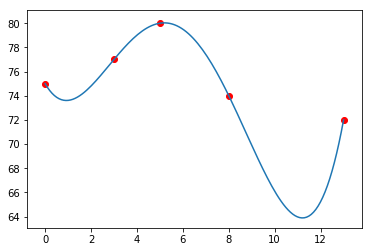

In [10]:
neville = np.array([[i, neville_interpolation(data1, i)] for i in indices])

plt.plot(neville[:,0], neville[:,1])
plt.scatter(data1[:, 0], data1[:, 1], marker='o', color='r')
plt.show()

#### Cubic Spline Interpolation

In [11]:
def find_index_spline(data, x):
    # Find the interval which x is in => the piece of the piecewise defined cubic to use
    index1 = np.where(data[:, 0] <= x)[0][-1]
    index2 = np.where(data[:, 0] >= x)[0][0]
    return int((index1+index2)/2)

def cubic_spline_value(data, x):
    a, b, c, d = cubic_spline(data)
    index = find_index_spline(data, x)
    return a[index] + b[index]*(x - data[index, 0]) + c[index]*(x - data[index, 0])**2 + d[index]*(x - data[index, 0])**3
    
def cubic_spline(data):
    a = np.empty(len(data))
    b = np.empty(len(data))
    c = np.empty(len(data))
    d = np.empty(len(data))
    a = data[:, 1]
    h = np.empty(len(data)-1)
    for i in range(len(h)):
        h[i] = data[i+1, 0] - data[i, 0]
    alpha = np.empty(len(data)-1)
    for i in range(1, len(data)-1):
        alpha[i] = 3/h[i] * (a[i+1] - a[i]) - 3/h[i-1] * (a[i] - a[i-1])
        
    l = np.empty(len(data)+1)
    mu = np.empty(len(data)+1)
    z = np.empty(len(data)+1)
    l[0] = 1
    mu[0] = 0
    z[0] = 0
    
    for i in range(1, len(data)-1):
        l[i] = 2*(data[i+1, 0] - data[i-1, 0]) - h[i-1]*mu[i-1]
        mu[i] = h[i]/l[i]
        z[i] = (alpha[i] - h[i-1]*z[i-1])/l[i]
        
    l[-1] = 1
    z[-1] = 0
    c[-1] = 0
    
    for j in range(len(data)-2, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (a[j+1] - a[j])/h[j] - h[j]*(c[j+1] + 2*c[j])/3
        d[j] = (c[j+1] - c[j])/(3*h[j])
        
    return a, b, c, d

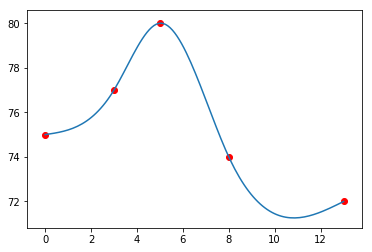

In [12]:
c_spline = np.array([[i, cubic_spline_value(data1, i)] for i in indices])


plt.plot(c_spline[:,0], c_spline[:,1])
#plt.plot(lagrange[:,0], lagrange[:,1], color='k')
plt.scatter(data1[:, 0], data1[:, 1], marker='o', color='r')
plt.show()

### Interpolating Known Functions

To get a deeper level of comparison between the Interpolation Methods, we try to use the examined interpolation methods on functions that we know beforehand, to see how close they get to the result. The functions we will look at here are:
- f(x)=exp(x)
- f(x)=sin(x)
- f(x)=x
- f(x)=x^4

In [13]:
# Testing Routine
def plot_all_methods(data, interpolation_indices):
    lagrange = np.array([[i, lagrange_polynomial_value(data, i)] for i in interpolation_indices])
    linear = np.array([[i, linear_interpolation_value(data, i)] for i in interpolation_indices])
    neville = np.array([[i, neville_interpolation(data, i)] for i in interpolation_indices])
    pw_linear = np.array([[i, piecewise_linear_interpolation_value(data, i)] for i in interpolation_indices])
    div_diff = np.array([[i, newton_divided_differences(data, i)] for i in interpolation_indices])
    c_spline = np.array([[i, cubic_spline_value(data, i)] for i in interpolation_indices])
    
        
    plt.figure()
    plt.title('Linear Interpolation')
    plt.scatter(data[:, 0], data[:, 1])
    plt.plot(linear[:, 0], linear[:, 1], color='g')
    
    plt.figure()
    plt.title('Piecewise-Linear Interpolation')
    plt.scatter(data[:, 0], data[:, 1])
    plt.plot(pw_linear[:, 0], pw_linear[:, 1], color='y')
    
    plt.figure()
    plt.title('Lagrange Interpolation')
    plt.scatter(data[:, 0], data[:, 1])
    plt.plot(lagrange[:, 0], lagrange[:, 1], color='b')
    
    plt.figure()
    plt.title('Neville\'s Method')
    plt.scatter(data[:, 0], data[:, 1])
    plt.plot(neville[:, 0], neville[:, 1], color='y')
    
    plt.figure()
    plt.title('Divided Differences')
    plt.scatter(data[:, 0], data[:, 1])
    plt.plot(div_diff[:, 0], div_diff[:, 1], color='m')

    plt.figure()
    plt.title('Cubic Spline Interpolation')
    plt.scatter(data[:, 0], data[:, 1])
    plt.plot(c_spline[:, 0], c_spline[:, 1], color='c')

    plt.show()

#### f(x)=exp(x)

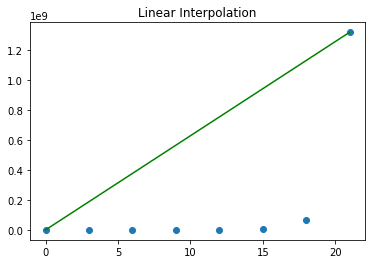

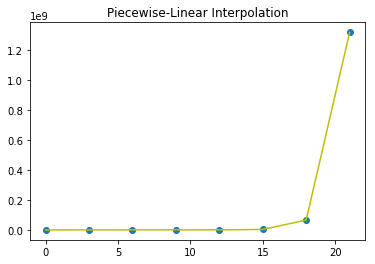

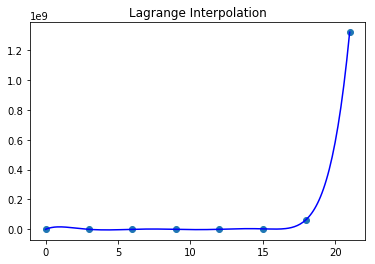

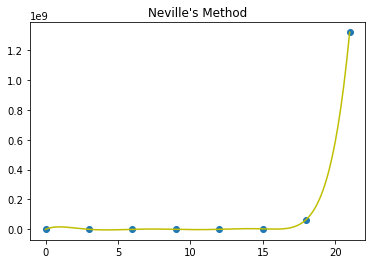

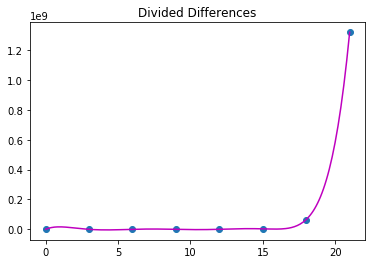

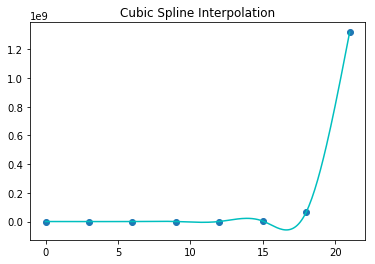

In [14]:
data_exp = np.array([[i, math.exp(i)] for i in range(0, 22, 3)])
interpolation_indices = np.linspace(0, 21, 210)
plot_all_methods(data_exp, interpolation_indices)

#### f(x)=sin(x)

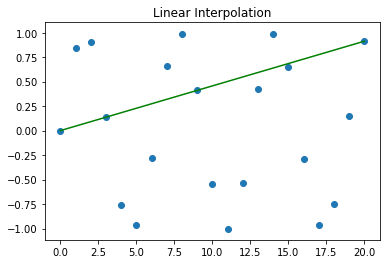

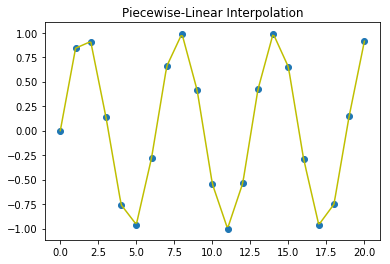

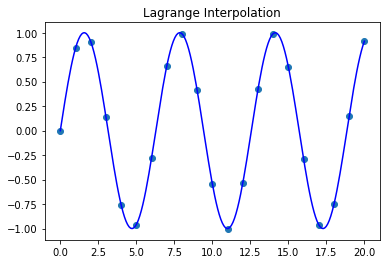

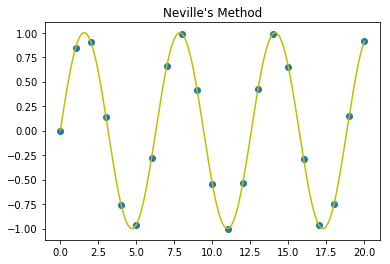

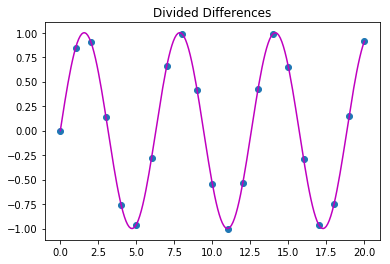

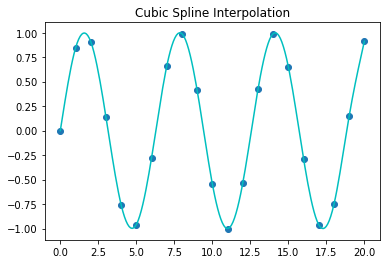

In [15]:
data_sin = np.array([[i, math.sin(i)] for i in range(0, 21)])
interpolation_indices = np.linspace(0, 20, 200)

plot_all_methods(data_sin, interpolation_indices)

#### f(x)=x

H:\python\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in long_scalars
  if __name__ == '__main__':


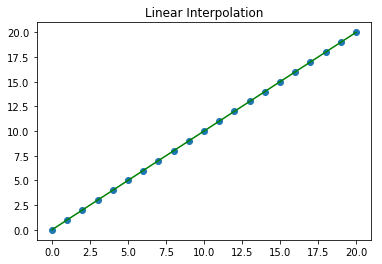

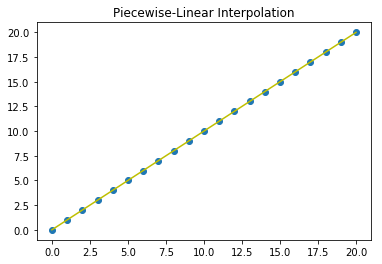

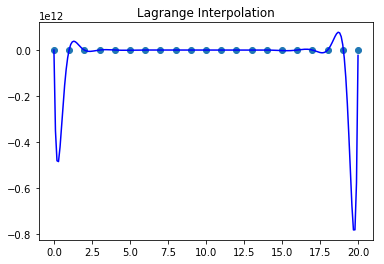

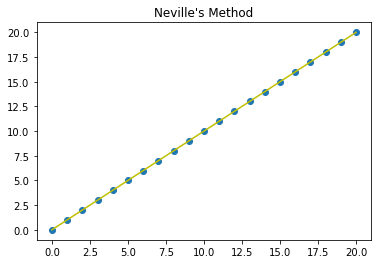

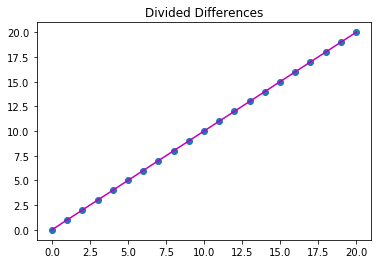

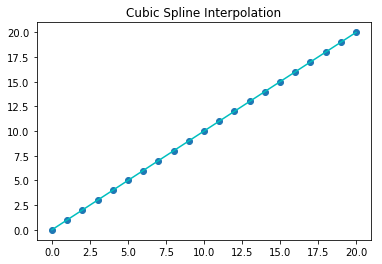

In [16]:
data_x = np.array([[i, i] for i in range(0, 21)])
interpolation_indices = np.linspace(0, 20, 200)

plot_all_methods(data_x, interpolation_indices)

#### f(x)=x^4

H:\python\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in long_scalars
  if __name__ == '__main__':


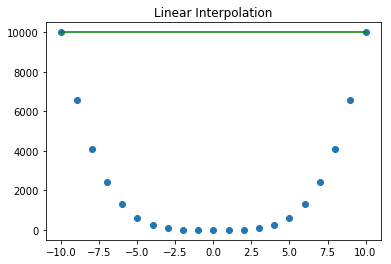

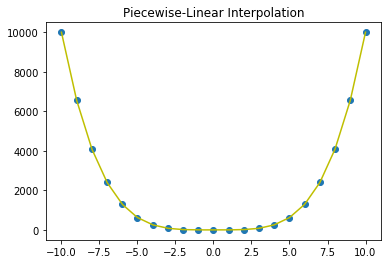

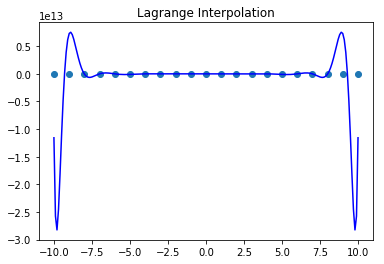

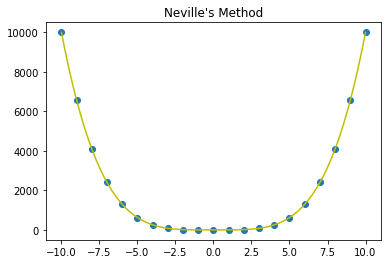

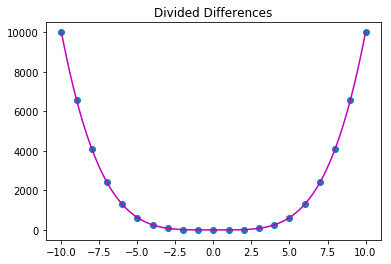

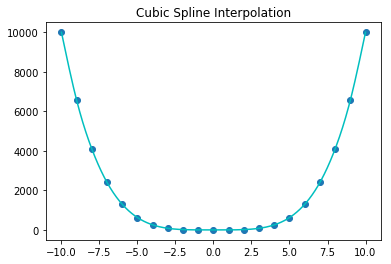

'\ndata_indices = np.linspace(-1, 1, 400)\ndata_x4 = np.array([[i, i**16 + i**4 - 2*i**2 + 1 ] for i in data_indices])\n\ninterpolation_indices = np.linspace(-1, 1, 60)\nplot_all_methods(data_x4, interpolation_indices)\n'

In [17]:

data_x4 = np.array([[i, i**4] for i in range(-10, 11)])
interpolation_indices = np.linspace(-10, 10, 200)

plot_all_methods(data_x4, interpolation_indices)

"""
data_indices = np.linspace(-1, 1, 400)
data_x4 = np.array([[i, i**16 + i**4 - 2*i**2 + 1 ] for i in data_indices])

interpolation_indices = np.linspace(-1, 1, 60)
plot_all_methods(data_x4, interpolation_indices)
"""

### Error Examination

#### Cross Validation

In [18]:
def cross_validation(data, index, method, plot=False):
    val_to_check = data[index]
    data_del = np.delete(data, index, axis=0)
    res = method(data_del, val_to_check[0])
    if plot:
        assert len(indices) > 0
        m_res = np.array([[i, method(data_del, i)] for i in indices])
        
        plt.plot(m_res[:,0], m_res[:,1])
        plt.scatter(data_del[:, 0], data_del[:, 1], marker='o', color='k')
        plt.scatter(val_to_check[0], val_to_check[1], marker='o', color='r')
        plt.show()
    return abs(res - val_to_check[1])

def cross_validate_method_for_all_points(data, method, plot=False):
    error_sum = 0
    for i in range(1, len(data)-1):
        error_sum += cross_validation(data, i, method, plot)
    return error_sum

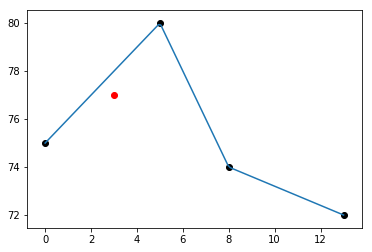

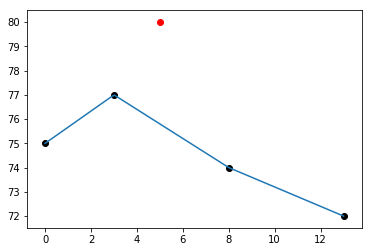

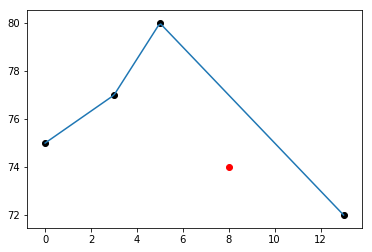

The error sum for the Piecewise Linear Interpolation Method on the first example Dataset is: 8.200000000000003


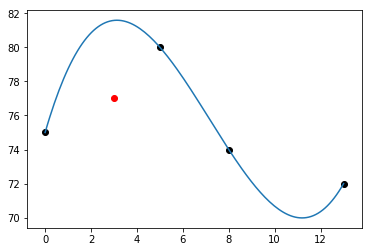

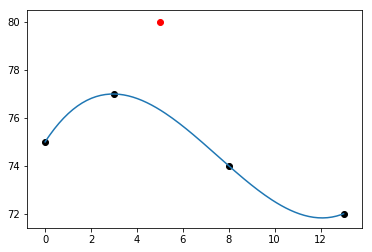

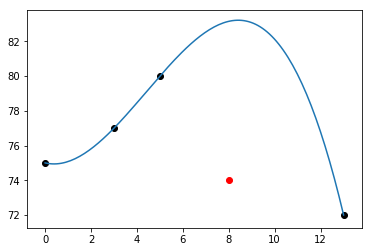

The error sum for the Lagrange Interpolation Method on the first example Dataset is: 17.392307692307682
The error sum for the Divided Differences Interpolation Method on the first example Dataset is: 17.392307692307696
The error sum for Neville's Method on the first example Dataset is: 17.39230769230771


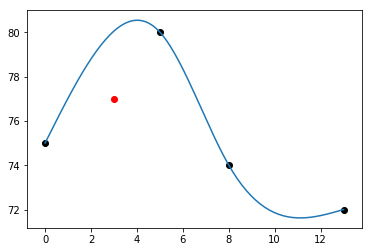

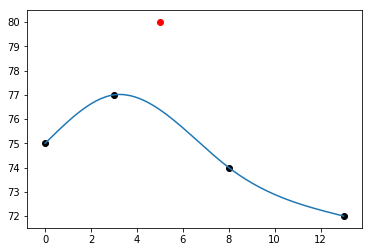

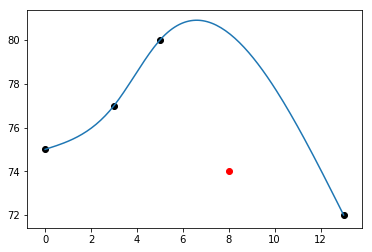

The error sum for the Cubic Spline Interpolation Method on the first example Dataset is: 12.982980754176367


In [19]:
error_pw_linear = cross_validate_method_for_all_points(data1, piecewise_linear_interpolation_value, plot=True)
print(f'The error sum for the Piecewise Linear Interpolation Method on the first example Dataset is: {error_pw_linear}')

error_lagrange = cross_validate_method_for_all_points(data1, lagrange_polynomial_value, plot=True)
print(f'The error sum for the Lagrange Interpolation Method on the first example Dataset is: {error_lagrange}')

error_div_diff = cross_validate_method_for_all_points(data1, newton_divided_differences)
print(f'The error sum for the Divided Differences Interpolation Method on the first example Dataset is: {error_div_diff}')

error_neville = cross_validate_method_for_all_points(data1, neville_interpolation)
print(f'The error sum for Neville\'s Method on the first example Dataset is: {error_neville}')

error_cubic = cross_validate_method_for_all_points(data1, cubic_spline_value, plot=True)
print(f'The error sum for the Cubic Spline Interpolation Method on the first example Dataset is: {error_cubic}')

#### Comparing to Known Functions

##### f(x)=sin(x)

In [46]:
indices_field = np.linspace(0, 6, 60)

data_sin = np.array([[i, math.sin(i)] for i in indices_field])
data_e = np.array([[i, math.exp(i)] for i in indices_field])
data_x = np.array([[i, i] for i in indices_field])
data_x4 = np.array([[i, i**4] for i in indices_field])

values_to_check = np.arange(0.5, 6, 1)

def get_error_for_all_methods(data, verbatim=False, f=math.sin):
    error_linear = get_error_for_method(data, piecewise_linear_interpolation_value, f)
    error_lagrange = get_error_for_method(data, lagrange_polynomial_value, f)
    error_div_diff = get_error_for_method(data, newton_divided_differences, f)
    error_neville = get_error_for_method(data, neville_interpolation, f)
    error_c_spline = get_error_for_method(data, cubic_spline_value, f)
    
    if verbatim:
        print(f'The error for the Piecewise Linear Interpolation Method is: {error_linear}')
        print(f'The error for the Lagrange Interpolation Method is: {error_lagrange}')
        print(f'The error for the Divided Differences Interpolation Method is: {error_div_diff}')
        print(f'The error for Neville\'s Interpolation Method is: {error_neville}')
        print(f'The error for the Cubic Spline Interpolation Method is: {error_c_spline}')
    
    return error_linear, error_lagrange, error_div_diff, error_neville, error_c_spline

def get_error_for_method(data, method, f=math.sin):
    error = 0
    for i in values_to_check:
        error += abs(f(i) - method(data, i))
    return error

In [47]:
print('f(x)=sin(x)')
_, _, _, _, _ = get_error_for_all_methods(data_sin, verbatim=True)
print()

print('f(x)=e^x')
_, _, _, _, _ = get_error_for_all_methods(data_e, verbatim=True, f=math.exp)
print()

print('f(x)=x')
_, _, _, _, _ = get_error_for_all_methods(data_x, verbatim=True, f=lambda x: x)
print()

print('f(x)=x^4')
_, _, _, _, _ = get_error_for_all_methods(data_x4, verbatim=True, f=lambda x: x**4)

f(x)=sin(x)
The error for the Piecewise Linear Interpolation Method is: 0.0035716250959832996
The error for the Lagrange Interpolation Method is: 2.8185715983397586e-08
The error for the Divided Differences Interpolation Method is: 7.4142683659239594e-09
The error for Neville's Interpolation Method is: 4.021517063801383e-09
The error for the Cubic Spline Interpolation Method is: 7.008295456745195e-07

f(x)=e^x
The error for the Piecewise Linear Interpolation Method is: 0.2502379982035543
The error for the Lagrange Interpolation Method is: 1.3354809351717734e-06
The error for the Divided Differences Interpolation Method is: 2.3568883822377984e-07
The error for Neville's Interpolation Method is: 3.853446783885772e-08
The error for the Cubic Spline Interpolation Method is: 0.000176228586506344

f(x)=x
The error for the Piecewise Linear Interpolation Method is: 0.0
The error for the Lagrange Interpolation Method is: 9.852575766355898e-08
The error for the Divided Differences Interpolation 

H:\python\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
H:\python\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


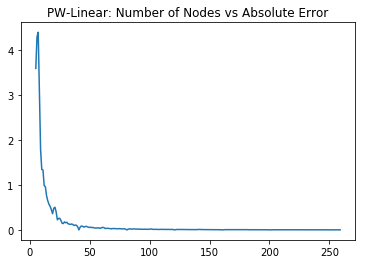

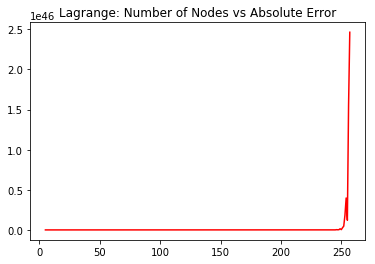

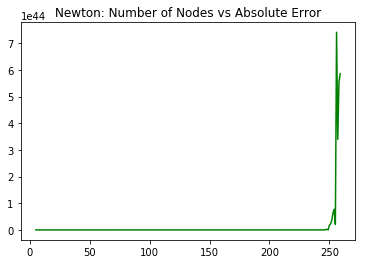

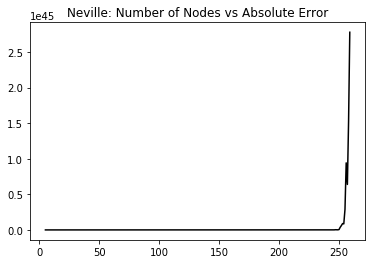

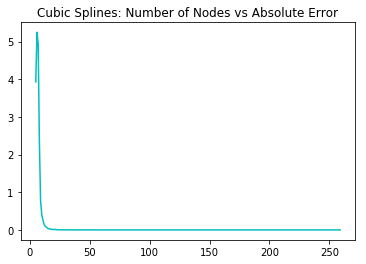

In [50]:
amount_of_nodes = np.array(list(range(5, 260)))

error_lin_list = np.empty(len(amount_of_nodes))
error_lag_list = np.empty(len(amount_of_nodes))
error_new_list = np.empty(len(amount_of_nodes))
error_nev_list = np.empty(len(amount_of_nodes))
error_csp_list = np.empty(len(amount_of_nodes))

for i in range(len(amount_of_nodes)):
    
    indices_field_test = np.linspace(0, 20, amount_of_nodes[i])
    data_sin_test = np.array([[i, math.sin(i)] for i in indices_field_test])
    e_lin, e_lag, e_new, e_nev, e_csp = get_error_for_all_methods(data_sin_test)
    error_lin_list[i] = e_lin
    error_lag_list[i] = e_lag
    error_new_list[i] = e_new
    error_nev_list[i] = e_nev
    error_csp_list[i] = e_csp
    
# print(error_lag_list)
plt.figure()
plt.title('PW-Linear: Number of Nodes vs Absolute Error')
plt.plot(amount_of_nodes, error_lin_list)

plt.figure()
plt.title('Lagrange: Number of Nodes vs Absolute Error')
plt.plot(amount_of_nodes, error_lag_list, color='r')

plt.figure()
plt.title('Newton: Number of Nodes vs Absolute Error')
plt.plot(amount_of_nodes, error_new_list, color='g')

plt.figure()
plt.title('Neville: Number of Nodes vs Absolute Error')
plt.plot(amount_of_nodes, error_nev_list, color='k')

plt.figure()
plt.title('Cubic Splines: Number of Nodes vs Absolute Error')
plt.plot(amount_of_nodes, error_csp_list, color='c')
plt.show()